# Lecture des données géospatiales


Pour relier les données de rendement de production annuelle d'avoine aux données météorologiques annuelles, nous devons utiliser des données géospatiales et la librairie geopandas.

Les données géospatiales des régions ("district") peuvent être téléchargées.  Il existe plusieurs formats de données géospatiales.  Nous utiliserons les shape files (.shp).

https://geohub.lio.gov.on.ca/datasets/municipal-boundary-upper-tier-and-district/explore?location=46.487638%2C-81.744527%2C4.73&showTable=true




<img src='https://drive.google.com/uc?export=view&id=1S3lIKmZdOe0-PchH9-ITBmdvbn0zPEO3' width='450px'>

Nous allons placer les stations météorologiques dans ces régions.



### Installation et chargement des librairies python

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  

Voici une description de certaines des librairies utilisées.

- `os` permet d'utiliser des fonctions liées aux fichiers sur disque et au système d'exploitation.
- `collections`  fournit des structures de données supplémentaires et des alternatives aux types de données intégrés (built-in) 
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)
- `geopandas` étend les fonctionnalités de la bibliothèque Pandas pour la manipulation et l'analyse des données géospatiales.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

#!pip install geopandas
import geopandas as gpd

#!pip install ydata_profiling
#from ydata_profiling import ProfileReport
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # palette IVADO

In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#%cd /content/drive/My Drive/Notebook_Dataset

### Lecture du shapefile avec geopandas

Le fichier .shp contient les coordonnées de polygones représentant les contours des régions administratives ontariennes.   Il est possible de représenter graphiquement les régions sous forme de carte.  Le fichier récupéré contient aussi le nom des régions. 

 Nous allons donc nous servir :
 
* du nom des régions pour faire le chevauchement avec les données de rendement
* les coordonnées géographiques des stations météorologiques pour faire le lien avec les données météorologiques

In [3]:
! ls ../data/raw/LIO-2022-10-19

MUNIC_BND_UPPER_AND_DIST.dbf MUNIC_BND_UPPER_AND_DIST.shp
MUNIC_BND_UPPER_AND_DIST.prj MUNIC_BND_UPPER_AND_DIST.shx


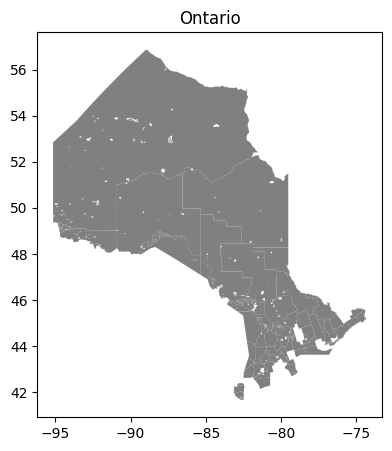

In [4]:
# Ceci prend environ 30-60 secondes à exécuter sur un macbook pro 2019
data_path = "../data/raw/"
ontario_shp = os.path.join(data_path, "LIO-2022-10-19/MUNIC_BND_UPPER_AND_DIST.shp")
ontario = gpd.read_file(ontario_shp)
ontario.plot(figsize=(10, 5), color='grey')
plt.title("Ontario")
plt.show()

In [5]:
ontario.head(3)

,OGF_ID,SUBTYPE,STYPE_NUM,MUN_NAME,MUNID,MAH_CODE,EXTENT_T,ASSESS_C,NAME_PREF,NAME_SHORT,GUNT_DES,GEO_UPD_DT,EFF_DATE,geometry
0,67907495,Upper Tier Municipality,70,COUNTY OF NORTHUMBERLAND,14000,61074,Islands,1400,COUNTY OF,NORTHUMBERLAND,2561,20220909134431,20220909103055,"MULTIPOLYGON (((-77.74251 43.97720, -77.74248 ..."
1,67907531,Upper Tier Municipality,70,COUNTY OF MIDDLESEX,39000,59000,Mainland,3900,COUNTY OF,MIDDLESEX,2561,20220909134432,20220909103101,"MULTIPOLYGON (((-81.43651 42.79026, -81.43651 ..."
2,67907554,Upper Tier Municipality,70,COUNTY OF FRONTENAC,10000,46000,Water,1000,COUNTY OF,FRONTENAC,2561,20220909134434,20220909103107,"POLYGON ((-76.16528 44.28195, -76.16429 44.240..."


In [6]:
ontario.columns

Index(['OGF_ID', 'SUBTYPE', 'STYPE_NUM', 'MUN_NAME', 'MUNID', 'MAH_CODE',
       'EXTENT_T', 'ASSESS_C', 'NAME_PREF', 'NAME_SHORT', 'GUNT_DES',
       'GEO_UPD_DT', 'EFF_DATE', 'geometry'],
      dtype='object')

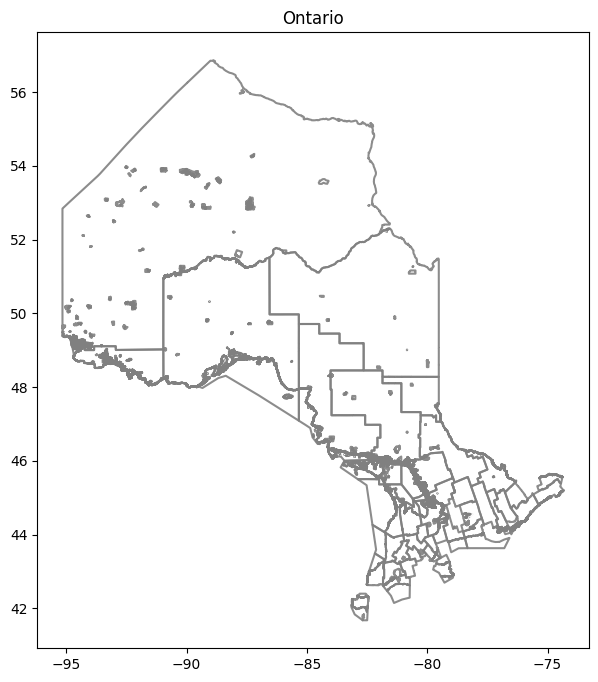

In [7]:
ontario.boundary.plot(color='grey', alpha=0.9, figsize=(13, 8))
plt.title("Ontario")
plt.show()

## Lecture données de rendement de la production d'avoine

In [8]:
id = "1uyw4fhzAU02luKzqReeXqZ2YoPw39FnM"  
url = "https://drive.google.com/uc?export=view&id=%s" % id
oats = pd.read_csv(url)

## Lecture données météorologiques

In [9]:
id = '1fxErsrmr5QdEOXQN6sWx3wEH-P6YpDnF'
url = "https://drive.google.com/uc?export=view&id=%s" % id
weather = pd.read_csv(url)

## Chevauchement dans les données

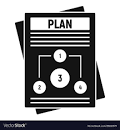


<span style='font-size:20px'>
Il faut intégrer les deux jeux de données ensemble, soit les données météorologiques et les données de rendement de la production d'avoine.

Comment faire ? 

1-  Associer les données de rendement de production d'avoine aux données géograghiques des régions ontariennes par nom de région.

2-  Associer les stations météorologiques aux régions ontariennes en utilisant les coordonnées géographiques des régions et des stations.

3 - Aggréger les valeurs collectées par des stations météo se trouvant dans une même région.

</span>

### Étape 1 - Données de rendement d'avoine + données géographiques

<br>

<span style='font-size:20px'>
Avant de procéder avec la première étape, nous devons vérifier que les noms de régions dans les données de rendement et dans les données géographiques sont les mêmes.
Ils doivent être identiques car ils serviront de clés pour fusionner les deux jeux de données.
</span>

In [10]:
ontario.loc[:,'Region'] = [c.title() for c in ontario.NAME_SHORT]
oats.loc[:,'Region'] = [c.title() for c in oats.Region]
ontario_regions = sorted(ontario.Region.unique())
oats_regions = sorted(oats.Region.unique().tolist())
regions_common = set(ontario_regions) & set(oats_regions)
diff_regions = list(set(ontario_regions).difference(set(oats_regions)))

In [11]:
print(F'Nombre de régions communes: {len(regions_common)}')
print(F'Nombre de régions dans le fichier de régions: {len(ontario_regions)}')
print(F'Nombre de régions dans le fichier de rendement: {len(oats_regions)}')

print()
print(F"Régions dans le shapefile ne se trouvant pas dans le fichier de rendement : {len(diff_regions)}/{len(oats_regions)}")
print(', '.join(diff_regions))

diff_regions = list(set(oats_regions).difference(set(ontario_regions)))
print(F"Régions dans le fichier de rendement ne se trouvant pas dans le shapefile : {len(diff_regions)}/{len(ontario_regions)}")
print(', '.join(diff_regions))

Nombre de régions communes: 40
Nombre de régions dans le fichier de régions: 40
Nombre de régions dans le fichier de rendement: 50

Régions dans le shapefile ne se trouvant pas dans le fichier de rendement : 0/50

Régions dans le fichier de rendement ne se trouvant pas dans le shapefile : 10/40
Brant, Prescott And Russell United, Ottawa, Hamilton, Haldimand-Norfolk, Chatham-Kent, Leeds And Grenville United, Grand Sudbury, Prince Edward, Kawartha Lakes


In [12]:
ontario_oats = ontario.merge(oats, on='Region', how='left')
ontario_oats.columns

Index(['OGF_ID', 'SUBTYPE', 'STYPE_NUM', 'MUN_NAME', 'MUNID', 'MAH_CODE',
       'EXTENT_T', 'ASSESS_C', 'NAME_PREF', 'NAME_SHORT', 'GUNT_DES',
       'GEO_UPD_DT', 'EFF_DATE', 'geometry', 'Region', 'Unnamed: 0',
       'Ensemencee', 'Recoltee', 'Rendement', 'Production_boiseaux',
       'Production_tonnes', 'Onglet', 'Annee'],
      dtype='object')

Regardons de quoi avait l'air le rendement d'avoine dans les différentes régions de l'Ontario pour une année donnée.  


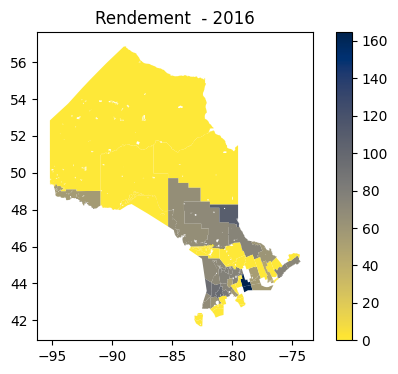

In [13]:
# Compter 30-40 secondes (ou plus)
def plot_map(df, year, var, figsize=(6, 4)):
    df.loc[df.Annee==year,:].plot(
        column=var,
        cmap='cividis_r',
        legend=True,
        figsize=figsize,
        missing_kwds={
            "color": "lightgrey",
            "label": "Missing values",
        },
    )
    plt.title(F"{var.title()}  - {year}")
    plt.show()
    
plot_map(ontario_oats, 2016, 'Rendement')

In [ ]:
plot_map(ontario_oats, 2020, 'Recoltee')

In [ ]:
En 2020, la plupart des acres récoltées se trouvaient au sud ouest.

### Étapes 2  -  Données de rendement + données géographiques + Données météo

In [14]:
# (comptez 20 secondes)
# Intégration des données de météo aux données de régions ontariennes
geometry = gpd.points_from_xy(weather.LONGITUDE, weather.LATITUDE)
weather_gdf = gpd.GeoDataFrame(weather, geometry=geometry)

# Intégration des données météo+geo aux données de rendement+géo
joined = gpd.sjoin(weather_gdf, ontario_oats, how="right", predicate="within")
joined = joined.loc[joined.STATION_NAME.notnull(),:]
joined.LOCAL_YEAR = joined.LOCAL_YEAR.astype(int)
my_data = joined.loc[joined.LOCAL_YEAR==joined.Annee, :]

/var/folders/jc/f6v43psn1vs2wsxdh3svtxfh0000gn/T/ipykernel_27033/1027730978.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  joined = gpd.sjoin(weather_gdf, ontario_oats, how="right", predicate="within")


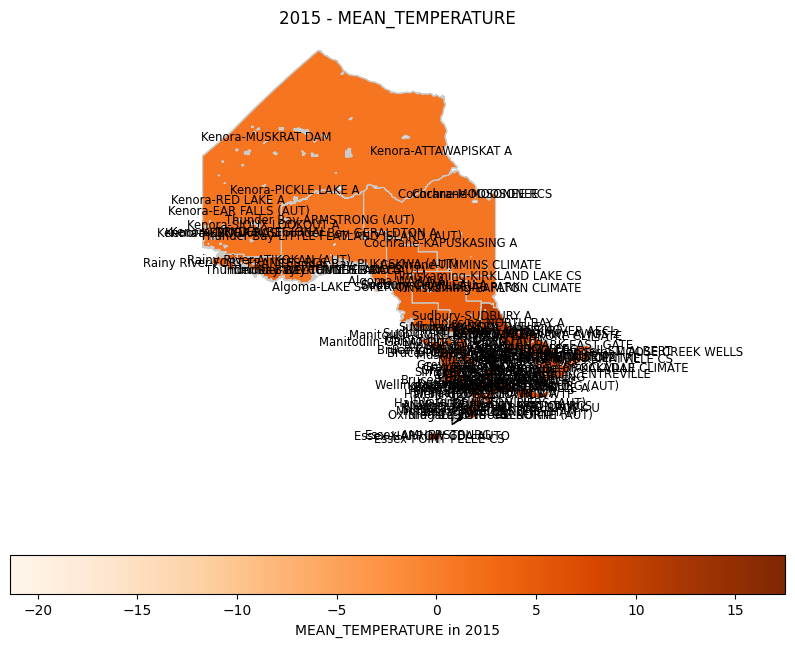

In [15]:
def plot_map_improved(dat, year, var, with_labels=True, figsize=(10, 8)):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.axis('off')
    ax.set_title('', fontdict={'fontsize': '5', 'fontweight' : '1'})
    color = 'Oranges'
    vmin = 0
    vmax = dat[var].max()*1.05

    mx = dat.loc[dat['LOCAL_YEAR']==year,:].drop_duplicates()
    mx.plot(var, cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(10,8),
          legend=True,
          legend_kwds={"label": f"{var} in {year}", "orientation": "horizontal"},
          missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "///",
        "label": "Missing values",
    },)
    if with_labels:
        tmp = mx.loc[:,['x', 'y', 'Region', 'STATION_NAME']].drop_duplicates()
        for idx, row in tmp.iterrows():
            plt.annotate(text=F"{row['Region']}-{row['STATION_NAME']}", xy=(row['x'], row['y']),
                    horizontalalignment='center', fontsize='small', color='black', wrap=True)
    plt.title(F'{year} - {var}')
    plt.show()

Il y a plusieurs stations météorologiques qui fait la collecte de données pour une même région géographique.
Elles sont parfois rapprochées et parfois plus éloignées.

In [ ]:
plot_map_improved(my_data, 2015, 'MEAN_TEMPERATURE', figsize=(10, 8))

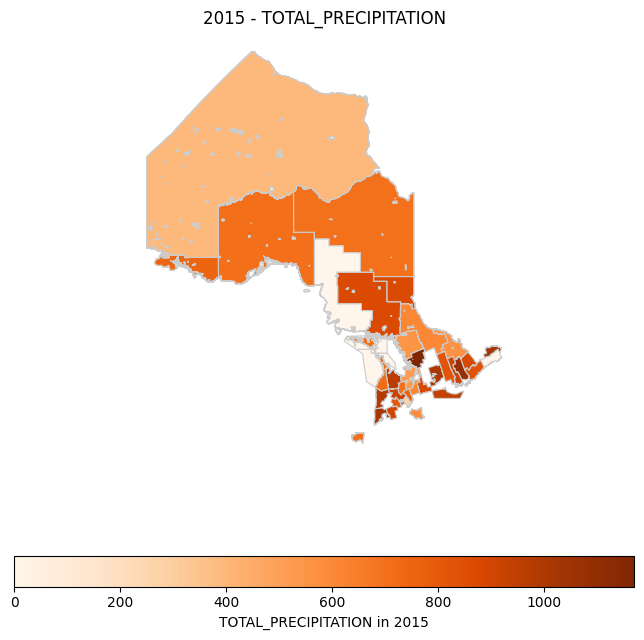

In [16]:
plot_map_improved(my_data, 2015, 'TOTAL_PRECIPITATION', with_labels=False, figsize=(8,8))

Certaines régions n'auraient reçu aucune précipitation en 2015 (valeur de 0). 
D'après vous, est-ce possible ?

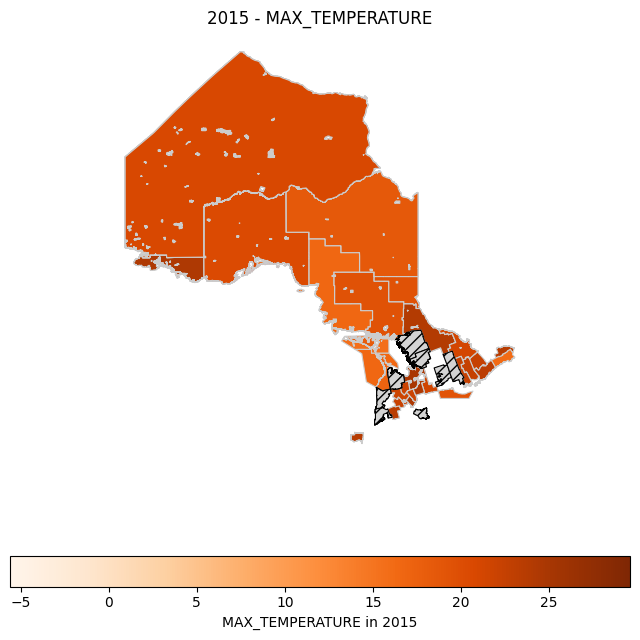

In [17]:
plot_map_improved(my_data, 2015, 'MAX_TEMPERATURE', with_labels=False, figsize=(8,8))

Certaines régions n'ont pas de données pour la température maximale enregistrée en 2015.

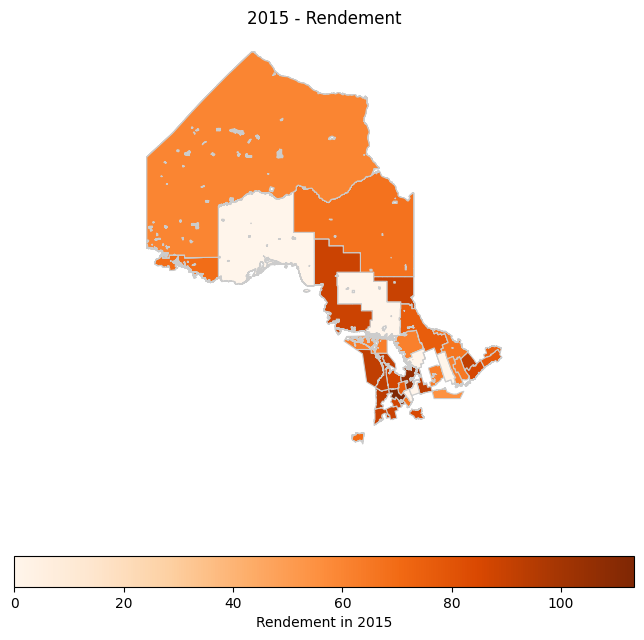

In [18]:
plot_map_improved(my_data, 2015, 'Rendement', with_labels=False, figsize=(8,8))

## Explorons un peu la matrice fusionnée 

Notre matrice de données contient maintenant les données de rendement et de météo.  Quelles informations pouvons-nous en tirer ?


Est-ce que nos données sont propres ou doivent-elles être nettoyées ?  Qu'en pensez-vous ?
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/genevieve/Documents/Travail/IVADO/Project/rendement_avoine_simple/.venv/lib/python3.8/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


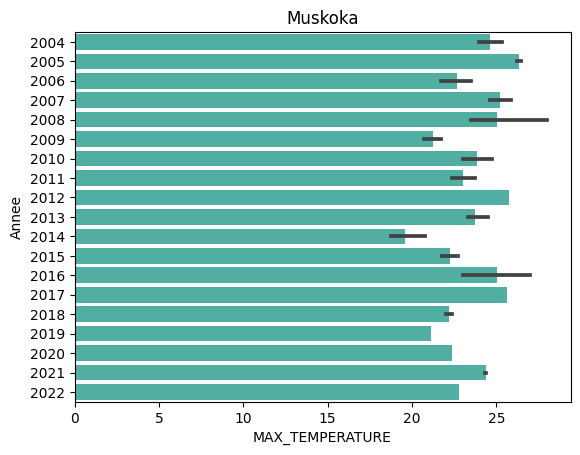

In [20]:
region = 'Muskoka'
sns.barplot(my_data.loc[my_data.Region==region,:],  x='MAX_TEMPERATURE', y='Annee', 
            orient='h', color=colors[0])
plt.title(region)
plt.show()

In [30]:
# Regardons les stations dont le nom contient 'BEATRICE' dans la région de Muskoka.  
# Les stations ne sont pas très éloignées. 
my_data.loc[my_data.STATION_NAME.str.contains("BEATRICE"), :].sort_values('LOCAL_YEAR').head(4)

,index_left,Unnamed: 0_left,LOCAL_YEAR,STATION_NAME,x,y,LATITUDE,LONGITUDE,CLIMATE_IDENTIFIER,MEAN_TEMPERATURE,...,geometry,Region,Unnamed: 0_right,Ensemencee,Recoltee,Rendement,Production_boiseaux,Production_tonnes,Onglet,Annee
1433,10.0,18.0,2004,BEATRICE 2,-79.400000,45.133333,45.133,-79.400,6110606,5.987903,...,"MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...",Muskoka,980,300.0,200.0,65.059396,13.01,0.200642,ots2004,2004
1431,239.0,437.0,2006,BEATRICE CLIMATE,-79.402778,45.140278,45.140,-79.403,6110607,5.566290,...,"MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...",Muskoka,874,229.0,200.0,47.000000,9.40,0.144968,oats2006,2006
1430,341.0,652.0,2007,BEATRICE CLIMATE,-79.402778,45.140278,45.140,-79.403,6110607,6.841452,...,"MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...",Muskoka,821,100.0,100.0,43.000000,4.30,0.066315,oats2007,2007
1430,340.0,651.0,2007,BEATRICE 2,-79.400000,45.133333,45.133,-79.400,6110606,8.252065,...,"MULTIPOLYGON (((-78.91925 45.52441, -78.91159 ...",Muskoka,821,100.0,100.0,43.000000,4.30,0.066315,oats2007,2007


### Observations    
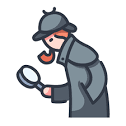

* Certaines régions n'ont pas de valeurs pour les températures (données manquantes)

* Il y a plusieurs stations pour une même région

* Il y a plusieurs mesures par annee par region, car il y a plusieurs stations meteo par region

* En 2022, il n’y a qu’une seule lecture qui s’aligne pas avec les autres dans certaines régions



In [22]:
station_names_nb = [s.split(' ')[0] for s in my_data.STATION_NAME.unique()]
station_names_nb = Counter(station_names_nb)
tb = [x for x in station_names_nb.most_common() if x[1] > 1]
tb

[('THUNDER', 6),
 ('MOOSONEE', 5),
 ('PORT', 4),
 ('EARLTON', 4),
 ('GORE', 4),
 ('MUSKOKA', 4),
 ('ST', 3),
 ('TILLSONBURG', 3),
 ('PETERBOROUGH', 3),
 ('FORT', 3),
 ('TIMMINS', 3),
 ('NORTH', 3),
 ('DRYDEN', 3),
 ('PICKLE', 3),
 ('PETAWAWA', 3),
 ('SARNIA', 3),
 ('THORNBURY', 2),
 ('PUKASKWA', 2),
 ('TERRACE', 2),
 ('ARMSTRONG', 2),
 ('GERALDTON', 2),
 ('VINELAND', 2),
 ('SUDBURY', 2),
 ('MONETVILLE', 2),
 ('OAKVILLE', 2),
 ('PARRY', 2),
 ('EGBERT', 2),
 ('MINE', 2),
 ('KAPUSKASING', 2),
 ('COBOURG', 2),
 ('TORONTO', 2),
 ('RAWSON', 2),
 ('KENORA', 2),
 ('SIOUX', 2),
 ('LANSDOWNE', 2),
 ('MUSKRAT', 2),
 ('BEATRICE', 2),
 ('SAULT', 2),
 ('WAWA', 2),
 ('PETROLIA', 2)]

In [23]:
t = pd.DataFrame()
for region in my_data.Region.unique():
  tmp = my_data.loc[my_data.Region==region,:]
  for year in tmp.LOCAL_YEAR.unique():
      tmp2 = tmp.loc[tmp.LOCAL_YEAR==year,:]
      tmp2 = tmp2.loc[:, ['LATITUDE', 'LONGITUDE',\
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE',\
       'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'DAYS_WITH_VALID_PRECIP',\
       'DAYS_WITH_PRECIP_GE_1MM', 'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_SNOWFALL',\
       'DAYS_WITH_VALID_SUNSHINE', 'Ensemencee',\
       'Recoltee', 'Rendement', 'Production_boiseaux', 'Production_tonnes',\
       'Annee']]
      tmp2 = tmp2.mean(0)
      tmp2['Region'] = region
      tmp2['Annee'] = year
      t = pd.concat([t, tmp2.T], axis=1)
t = t.T

tmp = t.copy()
tmp = tmp.drop_duplicates()
tmp.Annee = tmp.Annee.astype(int)
tmp.sort_values(['Rendement', 'Annee'], inplace=True)

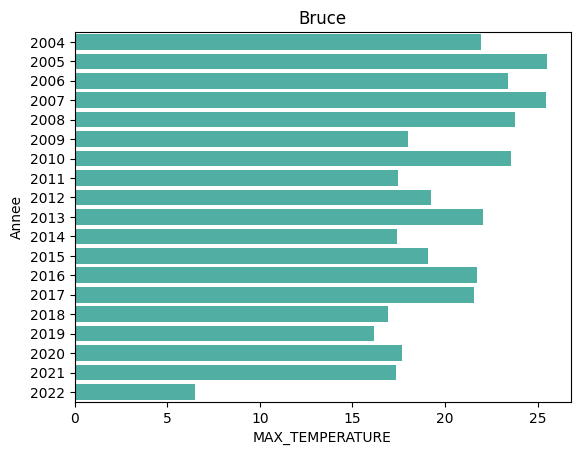

In [24]:
region = 'Bruce'
sns.barplot(tmp.loc[tmp.Region==region,:],  x='MAX_TEMPERATURE', y='Annee', orient='h', color=colors[0])
plt.title(region)
plt.show()

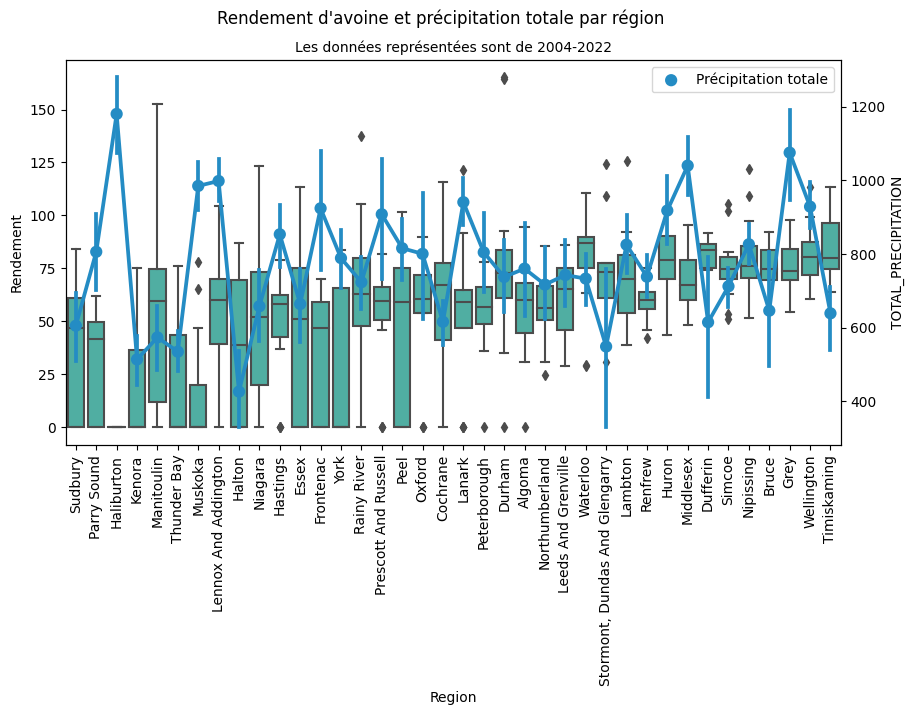

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(tmp, y='Rendement', x='Region', color=colors[0], ax=ax,)
plt.xticks(rotation=90)
ax2 = plt.twinx()
sns.pointplot(tmp,  y='TOTAL_PRECIPITATION', x='Region', color=colors[1], ax=ax2, label='Précipitation totale')
plt.xticks(rotation=90)
plt.suptitle("Rendement d'avoine et précipitation totale par région")
plt.title("Les données représentées sont de 2004-2022", fontsize=10)
plt.legend()
plt.show()

[]

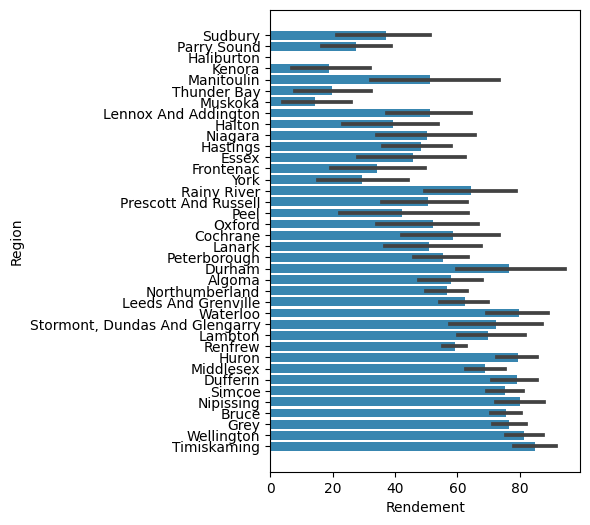

In [26]:
fig, ax = plt.subplots(figsize=(4,6))
sns.barplot(tmp,  x='Rendement', y='Region', orient='h', color=colors[1])#palette='Oranges')
plt.plot()

/var/folders/jc/f6v43psn1vs2wsxdh3svtxfh0000gn/T/ipykernel_27033/2466108352.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


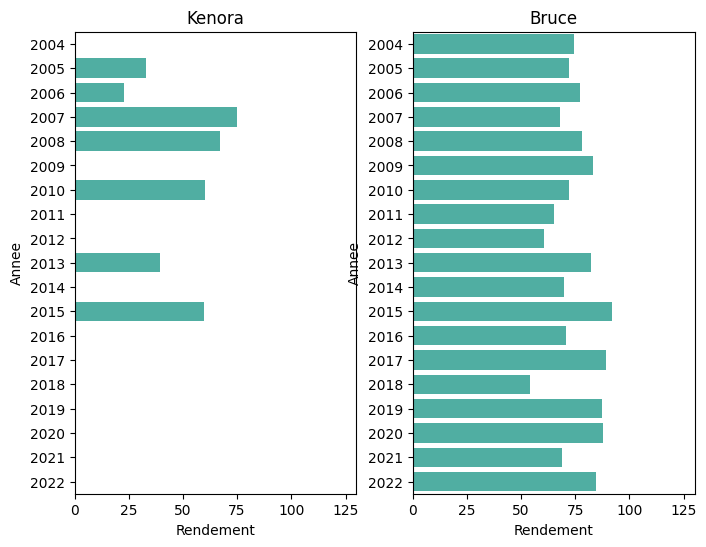

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
plt.subplot(1,2,1)
region = 'Kenora'
sns.barplot(tmp.loc[tmp.Region==region,:],  x='Rendement', y='Annee', orient='h', color=colors[0])
plt.title(region)
plt.xlim(0, 130)

plt.subplot(1,2,2)
region = 'Bruce'
sns.barplot(tmp.loc[tmp.Region==region,:],  x='Rendement', y='Annee', orient='h', color=colors[0])
plt.xlim(0, 130)
plt.title(region)
plt.show()

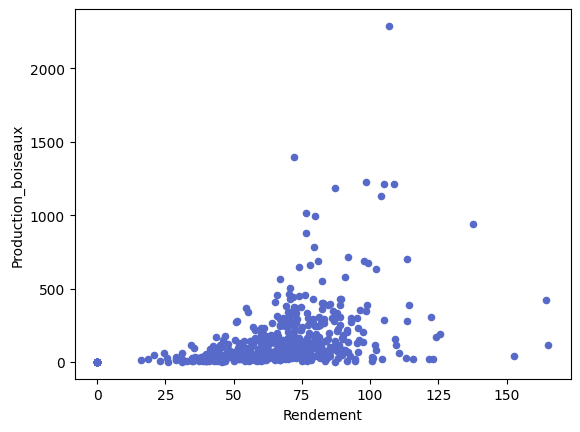

In [28]:
x = 'Rendement'
y = 'Production_boiseaux'
tmp.loc[:, [x,y]].plot.scatter(x, y, color=colors[3])
plt.show()

In [29]:
tmp.to_csv('dataset.csv')
my_data.to_csv('dataset_full.csv')